In [388]:
%matplotlib inline

import matplotlib
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

In [389]:
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
comp_train = fetch_20newsgroups(subset='all', categories=comp_categories, shuffle=True, random_state=42)
rec_train = fetch_20newsgroups(subset='all', categories=rec_categories, shuffle=True, random_state=42)
# comp_test = fetch_20newsgroups(subset='test', categories=comp_categories, shuffle=True, random_state=42)
# rec_test = fetch_20newsgroups(subset='test', categories=rec_categories, shuffle=True, random_state=42)

#all_points = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, shuffle=True, random_state=42)



# 1) Building the TF-IDF Matrix

In [390]:
# 1. transform the documents into TF-IDF vectors. 
# Use min df = 3, exclude the stopwords (no need to do stemming). Report the dimensions of the TF-IDF matrix you get.
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(min_df=3, stop_words=text.ENGLISH_STOP_WORDS) 
vectorized_corpus = vectorizer.fit_transform(comp_train.data + rec_train.data)

tfidf_transformer = TfidfTransformer()
trainX = tfidf_transformer.fit_transform(vectorized_corpus)

# testX = tfidf_transformer.transform(vectorizer.transform(comp_test.data + rec_test.data))

# 0 for comp class, 1 for rec class
trainy = np.zeros(shape=(len(comp_train.filenames) + len(rec_train.filenames),))
trainy[len(comp_train.filenames):] = 1

# testy = np.zeros(shape=(len(comp_test.filenames) + len(rec_test.filenames),))
# testy[len(comp_test.filenames):] = 1

In [391]:
print trainX.shape, trainy.shape

(7882, 27768) (7882,)


# 2) Applying K-Means

In [393]:
# 2. Apply K-means clustering with k = 2 using the TF-IDF data.
# Compare the clustering results with the known class labels.
# a) Inspect the contingency matrix to get a sense of your clustering result.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import contingency_matrix

km = KMeans(n_clusters=2, init='k-means++', max_iter=100)
km.fit(trainX)
ypred = km.predict(trainX)

In [394]:
print km.labels_.shape, testy.shape
print contingency_matrix(trainy, ypred, eps=None, sparse=False)

(7882,) (3150,)
[[3899    4]
 [2262 1717]]


In [395]:
# b) 5 Metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(trainy, ypred))
print("Completeness: %0.3f" % metrics.completeness_score(trainy, ypred))
print("V-measure: %0.3f" % metrics.v_measure_score(trainy, ypred))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(trainy, ypred))
print("Adjusted Mutual Info: %0.3f" % metrics.adjusted_mutual_info_score(trainy, ypred))

Homogeneity: 0.253
Completeness: 0.335
V-measure: 0.288
Adjusted Rand-Index: 0.181
Adjusted Mutual Info: 0.253


# 3) Preprocessing the data

In [396]:
# 3. a) Report the plot of the percent of variance the top r principle components can retain v.s. r, for r = 1 to 1000.
from scipy.sparse.linalg import svds

#Use SVD to find 1000 principal components
u, singular_values, vt = svds(trainX, k=1000)
print(len(singular_values))


1000


Text(0,0.5,u'retained variance ratio')

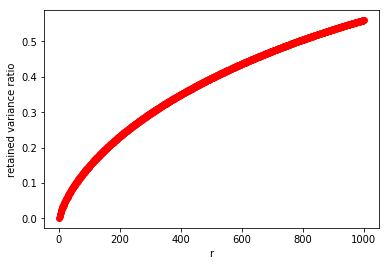

In [397]:
from sklearn.decomposition import TruncatedSVD, NMF

rs = np.arange(1, 1001)

svd = TruncatedSVD(n_components=1000)
svd.fit(trainX)
explained_vars = svd.explained_variance_ratio_

variances = np.zeros(explained_vars.shape)
variances[0] = explained_vars[0]
for i in range(1,1000):
    variances[i] = explained_vars[i] + variances[i-1]
    
plt.plot(rs, variances, 'ro')
plt.xlabel('r')
plt.ylabel('retained variance ratio')

In [411]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn import metrics


def get_scores(y, yhat):
    cont_matrix = contingency_matrix(y,yhat)# ypred)

    homogeneity = metrics.homogeneity_score(y, yhat)
    completeness_score = metrics.completeness_score(y, yhat)
    v_measure_score = metrics.v_measure_score(y, yhat)
    adjusted_rand_score = metrics.adjusted_rand_score(y, yhat)
    adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(y, yhat)
    return cont_matrix, homogeneity, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
   
    
def get_svd_scores(k,train_lsi=None, test_lsi=None, trainy=trainy, n_clusters=2):
    svd = TruncatedSVD(n_components=k)
    if train_lsi is None and test_lsi is None:
        train_lsi = svd.fit_transform(trainX)
#        test_lsi = svd.transform(testX)

    km = KMeans(n_clusters).fit(train_lsi)
#     km.fit(train_lsi)

    ypred = km.predict(train_lsi)
    return get_scores(trainy, ypred)
#     svd = TruncatedSVD(n_components=40)
#     X = svd.fit_transform(trainX)
#     kmeans = KMeans(n_clusters=2).fit(X)
#     svd2 = TruncatedSVD(n_components=2)
#     X2 = svd2.fit_transform(X)


    
def get_nmf_scores(num_components, train_nmf=None, test_nmf=None,trainy=trainy, n_clusters=2):
    nmf = NMF(n_components=num_components)
    if train_nmf is None and test_nmf is None:
        print("Using default NMF transform...")
        train_nmf = nmf.fit_transform(trainX)
      #  test_nmf = nmf.transform(testX)
    
    km = KMeans(n_clusters).fit(train_nmf)
    ypred = km.predict(train_nmf)
  
    return get_scores(trainy, ypred)
    

Text(0,0.5,u'singular val')

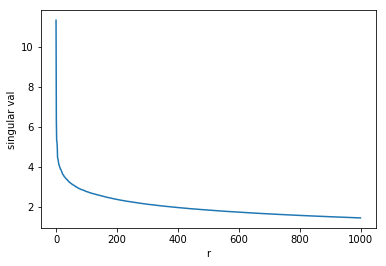

In [403]:
#print(sorted(singular_values, reverse=True))
sorted_singular_vals = sorted(singular_values, reverse=True)
plt.plot(sorted_singular_vals)
plt.xlabel('r')
plt.ylabel('singular val')

LSI...
('contingency matrix for r=', 1)
[[1703 2200]
 [1656 2323]]
('contingency matrix for r=', 2)
[[3713  190]
 [ 473 3506]]
('contingency matrix for r=', 3)
[[3866   37]
 [1422 2557]]
('contingency matrix for r=', 5)
[[3898    5]
 [2446 1533]]
('contingency matrix for r=', 10)
[[3900    3]
 [2374 1605]]
('contingency matrix for r=', 20)
[[   3 3900]
 [1607 2372]]
('contingency matrix for r=', 40)
[[3900    3]
 [2336 1643]]
('contingency matrix for r=', 50)
[[3900    3]
 [2353 1626]]
('contingency matrix for r=', 100)
[[3900    3]
 [2324 1655]]
('contingency matrix for r=', 300)
[[   4 3899]
 [1684 2295]]
r: 1 
 homogeneity=0.00030 
 completeness=0.00030 
 v-measure=0.00030 
 adj rand index=0.00034 
 adj mutual info=0.00021 
---
r: 2 
 homogeneity=0.59263 
 completeness=0.59424 
 v-measure=0.59343 
 adj rand index=0.69180 
 adj mutual info=0.59259 
---
r: 3 
 homogeneity=0.40097 
 completeness=0.43866 
 v-measure=0.41897 
 adj rand index=0.39656 
 adj mutual info=0.40091 
---
r: 5 
 

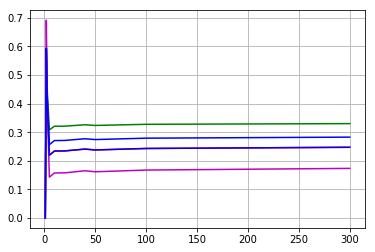

In [404]:
# b) LSI vs. NMF
# Specifically, try r = 1, 2, 3, 5, 10, 20, 40, 50, 100, 300, and plot the 5 
# measure scores v.s. r for both SVD and NMF; also report the contingency matrices for each r.
# Report the best r choice for SVD and NMF respectively.
# How do you explain the non-monotonic behavior of the measures as r increases?

r_vals = [1,2,3,5,10,20,40,50,100,300]
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
print("LSI...")
for r in r_vals:
    contin, h, c, v, rand, mutual = get_svd_scores(k=r)
#    contingency_matrices.append(contin)
    print("contingency matrix for r=", r)
#    print(h, c, v, rand, mutual)
    print(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list)) # not sure if this works e.g. [0,1,0,3,2,0]
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()
    
    



# Report the best r choice for SVD
The best r choice for SVD was r=2. The metric outputs were:<br>
r: 2<br>
 homogeneity=0.59263 <br>
 completeness=0.59424 <br>
 v-measure=0.59343  <br>
 adj rand index=0.69180 <br> 
 adj mutual info=0.59259 

NMF...
Using default NMF transform...
('contingency matrix for r=', 1)
[[2200 1703]
 [2323 1656]]
Using default NMF transform...
('contingency matrix for r=', 2)
[[3594  309]
 [ 158 3821]]
Using default NMF transform...
('contingency matrix for r=', 3)
[[3899    4]
 [2396 1583]]
Using default NMF transform...
('contingency matrix for r=', 5)
[[3898    5]
 [2677 1302]]
Using default NMF transform...
('contingency matrix for r=', 10)
[[3898    5]
 [2625 1354]]
Using default NMF transform...
('contingency matrix for r=', 20)
[[   7 3896]
 [ 800 3179]]
Using default NMF transform...
('contingency matrix for r=', 40)
[[3581  322]
 [3979    0]]
Using default NMF transform...
('contingency matrix for r=', 50)
[[   2 3901]
 [1045 2934]]
Using default NMF transform...
('contingency matrix for r=', 100)
[[3887   16]
 [3965   14]]
Using default NMF transform...
('contingency matrix for r=', 300)
[[3723  180]
 [3974    5]]
r: 1 
 homogeneity=0.00030 
 completeness=0.00030 
 v-measure=0.00030 
 adj

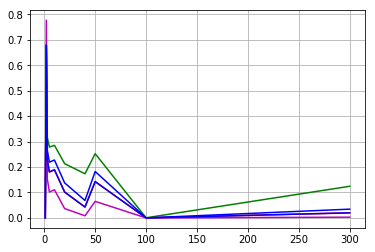

In [423]:
print("NMF...")   
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
# r_vals = [2,3,4,5]
for r in r_vals:
    contin, h, c, v, rand, mutual = get_nmf_scores(num_components=r)
    print("contingency matrix for r=", r)
    print(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))


res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list))
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()




# Report the best r choice for NMF
The best r-choice for NMF was r=2.
<br>
r: 2  <br>
 homogeneity=0.67905  <br>
 completeness=0.68013 <br>
 v-measure=0.67959 <br>
 adj rand index=0.77702 <br> 
 adj mutual info=0.67902  <br>

# How do you explain the non-monotonic behavior of the measures as r increases?
As we increase the number of dimensions r, more information is encapsulated in the feature representation just by nature of having a higher percentage of the variance due to more principal components. However, K-Means suffers from the curse of dimensionality, so as the dimensions increase, Euclidean distance becomes a worse and worse distance metric and will perform poorly. Thus, we are trading off between more information and an inherent shortcoming in the KMeans method. This is why it's possible for KMeans to perform better with lower dimension (such as r=2) than with higher dimension (such as r=300 or r=1000).


# 4) Visualizations and Transformations

In [424]:
#4a 
from sklearn.preprocessing import scale

#SVD
svd = TruncatedSVD(n_components=2)
train_lsi = svd.fit_transform(trainX)
#test_lsi = svd.transform(testX)

km = KMeans(n_clusters=2)
km.fit(train_lsi)
ypred = km.predict(train_lsi)

#NMF
nmf = NMF(n_components=2)
train_nmf = nmf.fit_transform(trainX)
#test_nmf = nmf.transform(testX)

km_nmf = KMeans(n_clusters=2)
km_nmf.fit(train_nmf)
ypred_nmf = km_nmf.predict(train_nmf)


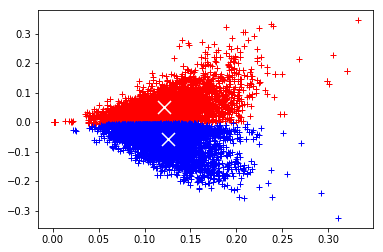

In [430]:
# use LSI w/ r=2
def plot_clusters(k, mode='lsi'):
    if mode is 'lsi':
        svd = TruncatedSVD(n_components=k)
    else:
        svd = NMF(n_components=k)
    X = svd.fit_transform(trainX)
    kmeans = KMeans(n_clusters=2).fit(X)
#    svd2 = TruncatedSVD(n_components=2)
#    X2 = svd2.fit_transform(X)
    X2 = X

    x1 = X2[kmeans.labels_ == 0][:, 0]
    y1 = X2[kmeans.labels_ == 0][:, 1]
    plt.plot(x1,y1,'r+')
    x2 = X2[kmeans.labels_ == 1][:, 0]
    y2 = X2[kmeans.labels_ == 1][:, 1]
    plt.plot(x2, y2, 'b+')
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
    plt.show()

plot_clusters(k=2)

In [431]:
from matplotlib.colors import ListedColormap

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

#print(X.shape)
def plot_kmeans(X, km_model):
    #step size in mesh
    h=0.2

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

#    print(xx.shape, yy.shape)
    Z = km_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    #plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    #plt.xlim(xx.min(), xx.max())
    #plt.ylim(yy.min(), yy.max())

    #plt.show()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = km_model.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-Means on reduced data showing centroids in white')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    #plt.xlim(0, 0.4)
    #plt.ylim(-0.4, 0.4)
    #plt.xticks(())
    #plt.yticks(())
    plt.show()

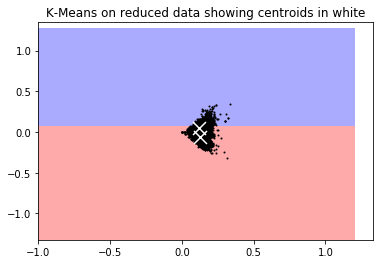

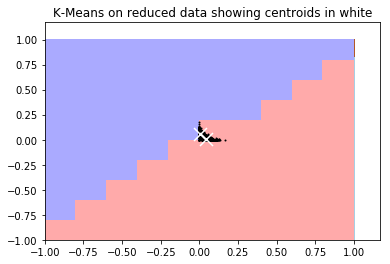

In [432]:
#X=scaled_train_lsi
#km_model = km
plot_kmeans(X=train_lsi, km_model=km)
plot_kmeans(X=train_nmf, km_model=km_nmf)



In [433]:
def sweep_metrics(train_vecs, names, km_model):
    #Store the different combinations
    contingency_matrices = []
    h_vals = []
    c_vals = []
    v_vals = []
    rand_vals = []
    mutual_vals = []
    
    for i in range(len(train_vecs)):
        print(names[i])
#         plot_kmeans(X=train_vecs[i], km_model=km_model)
        plot_clusters(X=train_vecs[i])
        contin, h, c, v, rand, mutual = get_nmf_scores(num_components=2, train_nmf=train_vecs[i], test_nmf=test_vecs[i])
        
        contingency_matrices.append(contin)
        h_vals.append(h)
        c_vals.append(c)
        v_vals.append(v)
        rand_vals.append(rand)
        mutual_vals.append(mutual)

    
    return (contingency_matrices, h_vals, c_vals, v_vals, rand_vals, mutual_vals)

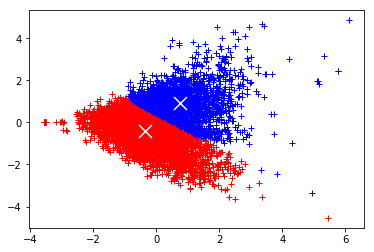

(array([[1703, 2200],
        [3734,  245]]),
 0.23561130934927968,
 0.26370524307218374,
 0.24886792677388714,
 0.25565100254867557,
 0.23554132635954544)

In [434]:
# LSI k=2, normalize

svd = TruncatedSVD(n_components=2)
# X = svd.fit_transform(trainX)
# print(X)
X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)
svd2 = TruncatedSVD(n_components=2)
X2 = X#svd2.fit_transform(X)

x1 = X2[kmeans.labels_ == 0][:, 0]
y1 = X2[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X2[kmeans.labels_ == 1][:, 0]
y2 = X2[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

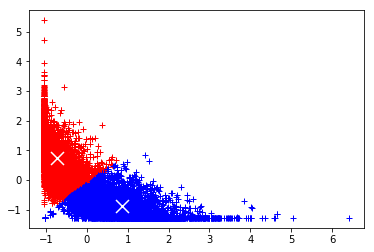

(array([[ 369, 3534],
        [3873,  106]]),
 0.68280383215740159,
 0.68564597521446458,
 0.68422195225245208,
 0.77344267746059059,
 0.68277479271669961)

In [440]:
# NMF k=2, normalize

svd = NMF(n_components=2)
# print(X)
X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)
# svd2 = TruncatedSVD(n_components=2)
# X2 = svd2.fit_transform(X)

x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()

ypred = kmeans.predict(X)
get_scores(trainy, ypred)

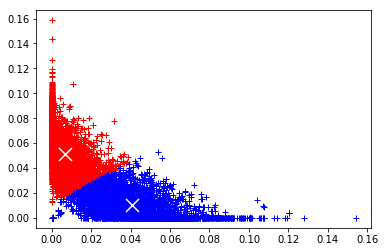

(array([[ 325, 3578],
        [3827,  152]]),
 0.67505483884223971,
 0.67640887404390404,
 0.67573117813728023,
 0.77255016042641178,
 0.67502509000059729)

In [441]:
# NMF Log transformation
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

# print(X)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(NMF(n_components=2), poly_transform)
X = nmf_norm_poly.fit_transform(trainX)
# X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)


x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3, color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

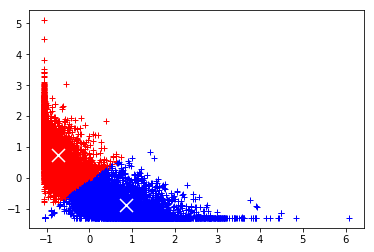

(array([[ 367, 3536],
        [3873,  106]]),
 0.68368793206160372,
 0.68649525835469694,
 0.68508871928580251,
 0.77433568617041104,
 0.68365897356118954)

In [442]:
# transform then scale
# print(X)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(NMF(n_components=2), poly_transform)
X = scale(nmf_norm_poly.fit_transform(trainX))
# X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=2).fit(X)

x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

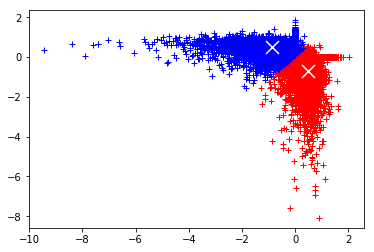

(array([[3613,  290],
        [ 226, 3753]]),
 0.65169556098080406,
 0.65196692333689155,
 0.65183121391628918,
 0.75524946970992446,
 0.65166367360706523)

In [443]:
# scale then transform
# print(X)
svd = NMF(n_components=2)
# print(X)
scaled = scale(svd.fit_transform(trainX))
# print(scaled)
poly_transform = FunctionTransformer(np.log1p)
X = np.nan_to_num(poly_transform.fit_transform(scaled))

kmeans = KMeans(n_clusters=2).fit(np.nan_to_num(X))

x1 = X[kmeans.labels_ == 0][:, 0]
y1 = X[kmeans.labels_ == 0][:, 1]
plt.plot(x1,y1,'r+')
x2 = X[kmeans.labels_ == 1][:, 0]
y2 = X[kmeans.labels_ == 1][:, 1]
plt.plot(x2, y2, 'b+')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=3,color='w', zorder=10)
plt.show()


ypred = kmeans.predict(X)
get_scores(trainy, ypred)

# 5: Expand Dataset into 20 categories

In [379]:
from sklearn.feature_extraction.text import TfidfVectorizer 

all_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42,  remove=('headers','footers','quotes'))
tfidf = TfidfVectorizer(analyzer='word', stop_words=text.ENGLISH_STOP_WORDS, min_df=3)

all_data_tfidf = tfidf.fit_transform(all_data.data)

In [382]:
#get data labels
labels_all_data = all_data.target
print(labels_all_data[:20], len(labels_all_data))

(array([10,  3, 17,  3,  4, 12,  4, 10, 10, 19, 19, 11, 19, 13,  0, 17, 12,
       12, 11,  8]), 18846)


In [383]:
#Raw without dimensionality reduction 
km = KMeans(n_clusters=20)
km.fit(all_data_tfidf)

ytrue = labels_all_data
ypred = km.labels_

get_scores(ytrue, ypred)


(array([[  0,   0,   3, 310,   0,   2,   0,   5,   1,  15,  33,   0,  15,
           2, 267,  17,   0, 119,   7,   3],
        [  0,   0, 265,  61,  51,   0,   5,   1,   1,   0,  15,   0,  18,
           3, 265,  19,  36,   0, 140,  93],
        [ 19,   0,  79,  54,  70,   0,   1,   0,   0,   0,  15,   0,  28,
           1, 238,  10, 286,   1,  59, 124],
        [190,   0,  37,  42, 213,   2,   3,   0,   2,   0,  27,   1,  16,
           5, 270,  16,  42,   0, 104,  12],
        [106,   0,  35,  82, 141,   0,   3,   0,   1,   0,  12,   0,  20,
           1, 407,  19,   5,   0, 124,   7],
        [  1,   0, 457,  34,  10,   0,   5,   0,   0,   0,  17,   0,  21,
           9, 224,   7,  48,   0, 100,  55],
        [ 67,   0,  12,  31,  61,  32,  92,   0,  19,   0,  32,   5,   3,
           1, 500,  45,  19,   0,  55,   1],
        [  3,   0,   2, 123,   0, 316,   2,   0,   0,  11,  17,   0,  16,
           1, 405,  63,   0,   0,  30,   1],
        [ 14,   0,   0, 295,   0,  32,   1,   0,

In [385]:
# LSI w/ n_components = 2 and 40 
svd_2 = TruncatedSVD(n_components=2)
svd_40 = TruncatedSVD(n_components=40)

lsi_total_2 = svd_2.fit_transform(all_data_tfidf)
lsi_total_40 = svd_40.fit_transform(all_data_tfidf)

km_2 = KMeans(n_clusters=20)
km_2.fit(lsi_total_2)

km_40 = KMeans(n_clusters=20)
km_40.fit(lsi_total_40)

ypred_2 = km_2.labels_
ypred_40 = km_40.labels_



In [386]:
#get scores for 2
get_scores(ytrue, ypred_2)


(array([[ 78,   1,  59,  11,   2,   4, 117,   2,   0,  55, 132, 164,  21,
           0,  24,   0,  80,   4,   0,  45],
        [  7, 159,   0, 113,  50,  25,  31, 104,  61,  46,   0,   3,   0,
         115,   0,  13,   1,  52, 146,  47],
        [  7, 109,   0,  80,  58,   9,  20,  76, 179,  72,   1,   4,   0,
          86,   0,  50,   2,  25, 195,  12],
        [  2, 154,   0,  83,  80,  10,  10,  85, 119,  36,   0,   1,   0,
         138,   0,  35,   1,  23, 192,  13],
        [  1, 159,   0, 130,  92,  17,  20, 111,  39,  63,   0,   1,   1,
         129,   0,   4,   1,  57, 109,  29],
        [  4, 199,   0, 175,  43,   7,  11, 154,  34,  43,   0,   3,   0,
         143,   0,  18,   2,  36,  97,  19],
        [  6, 150,   0, 196,  26,   8,  37, 172,  56,  67,   0,   4,   0,
          73,   0,   5,   1,  39,  99,  36],
        [ 78,  12,   2,  99,   5,  36, 140,  72,   0, 118,   6,  39,   2,
          22,   0,   0,  11, 133,   3, 212],
        [ 96,   4,   0,  81,   0,  33, 202,  50,

In [387]:
#get scores for 40
get_scores(ytrue, ypred_40)

(array([[  7, 322,  83,   0,   2,   3,   0,   0,   0,   2,   5, 262,   0,
           0,  93,   2,   0,  18,   0,   0],
        [166, 290,   0,   0,   0,   0,   0,  54,   0, 257,  10,  71,   0,
          90,   0,   2,   0,   0,   4,  29],
        [ 72, 240,   1,   0,   0,   0,   0,  77,  16, 157,   5,  49,   0,
          56,   0,   0,   2,   1,   1, 308],
        [ 97, 189,   0,   0,   3,   0,   0, 168, 126,  30,   1,  32,   3,
         220,   0,   3,  70,   0,   1,  39],
        [ 96, 228,   0,   0,   0,   0,   0,  54,  85,  14,   4,  45,   1,
         400,   0,   1,  29,   0,   1,   5],
        [123, 290,   0,   0,   0,   0,   0,   7,   1, 441,   4,  41,   0,
          21,   0,   8,   0,   0,   4,  48],
        [ 46, 236,   0,   0,  26,   0,   0,  35,  59,   0,   1,  23,  15,
         453,   0,   0,   7,   0,  63,  11],
        [ 36, 436,   0,   0, 332,   0,   0,   0,   3,   4,   0, 147,   0,
          16,   2,   1,   0,  11,   2,   0],
        [ 36, 537,   2,   0,  45,   0,   0,   0,

LSI...
('r-value: ', 1)
('r-value: ', 2)
('r-value: ', 3)
('r-value: ', 5)
('r-value: ', 10)
('r-value: ', 20)
('r-value: ', 50)
('r-value: ', 100)
('r-value: ', 300)
r: 1 
 homogeneity=0.01493 
 completeness=0.01617 
 v-measure=0.01552 
 adj rand index=0.00296 
 adj mutual info=0.01172 
---
r: 2 
 homogeneity=0.17491 
 completeness=0.18693 
 v-measure=0.18072 
 adj rand index=0.05088 
 adj mutual info=0.17223 
---
r: 3 
 homogeneity=0.21522 
 completeness=0.23610 
 v-measure=0.22518 
 adj rand index=0.06620 
 adj mutual info=0.21268 
---
r: 5 
 homogeneity=0.26777 
 completeness=0.29981 
 v-measure=0.28289 
 adj rand index=0.08846 
 adj mutual info=0.26540 
---
r: 10 
 homogeneity=0.27295 
 completeness=0.30771 
 v-measure=0.28929 
 adj rand index=0.08818 
 adj mutual info=0.27059 
---
r: 20 
 homogeneity=0.26848 
 completeness=0.32716 
 v-measure=0.29493 
 adj rand index=0.06832 
 adj mutual info=0.26610 
---
r: 50 
 homogeneity=0.27869 
 completeness=0.36216 
 v-measure=0.31499 
 ad

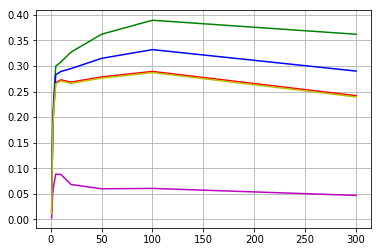

In [446]:
#Sweep LSI and NMF dimensions
r_vals = [1,2,3,5,10,20,50,100,300]
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
print("LSI...")
for r in r_vals:
    print("r-value: ", r)
    svd = TruncatedSVD(n_components=r)
    train_lsi = svd.fit_transform(all_data_tfidf)
        
    contin, h, c, v, rand, mutual = get_svd_scores(k=r, train_lsi=train_lsi, test_lsi=None, trainy=ytrue, n_clusters=20)
#    contingency_matrices.append(contin)
#    print("contingency matrix for r=", r)
#    print(h, c, v, rand, mutual)
 #   print(contin)
    contingency_matrices.append(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list)) # not sure if this works e.g. [0,1,0,3,2,0]
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'y', label="adjusted mutual information")
plt.grid()

NMF...
('r-value: ', 1)
('r-value: ', 2)
('r-value: ', 3)
('r-value: ', 5)
('r-value: ', 10)
('r-value: ', 20)
('r-value: ', 50)
('r-value: ', 100)
('r-value: ', 300)
r: 1 
 homogeneity=0.01499 
 completeness=0.01621 
 v-measure=0.01557 
 adj rand index=0.00300 
 adj mutual info=0.01179 
---
r: 2 
 homogeneity=0.16083 
 completeness=0.17157 
 v-measure=0.16603 
 adj rand index=0.04645 
 adj mutual info=0.15811 
---
r: 3 
 homogeneity=0.18415 
 completeness=0.20519 
 v-measure=0.19410 
 adj rand index=0.05338 
 adj mutual info=0.18149 
---
r: 5 
 homogeneity=0.21905 
 completeness=0.26077 
 v-measure=0.23810 
 adj rand index=0.06555 
 adj mutual info=0.21649 
---
r: 10 
 homogeneity=0.26164 
 completeness=0.31622 
 v-measure=0.28635 
 adj rand index=0.07139 
 adj mutual info=0.25923 
---
r: 20 
 homogeneity=0.22135 
 completeness=0.29280 
 v-measure=0.25211 
 adj rand index=0.04585 
 adj mutual info=0.21881 
---
r: 50 
 homogeneity=0.17142 
 completeness=0.26640 
 v-measure=0.20861 
 ad

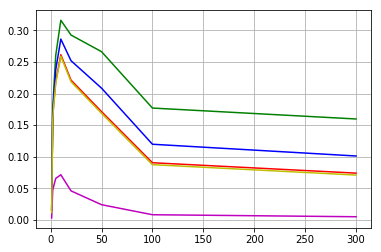

In [447]:
print("NMF...")   
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
# r_vals = [2,3,4,5]
for r in r_vals:
    print("r-value: ", r)
    nmf = NMF(n_components=r)
    train_nmf = nmf.fit_transform(all_data_tfidf)
        
    contin, h, c, v, rand, mutual = get_nmf_scores(num_components=r, train_nmf=train_nmf, test_nmf=None, trainy=ytrue, n_clusters=20)
    
 #   print("contingency matrix for r=", r)
#    print(contin)
    contingency_matrices.append(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))


res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list))
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'y', label="adjusted mutual information")
plt.grid()





In [454]:
# LSI k=100, normalize

svd = TruncatedSVD(n_components=100)
# X = svd.fit_transform(trainX)
# print(X)
X = scale(svd.fit_transform(all_data_tfidf))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=20).fit(X)

ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[  0,   1,   4,   1,   0,  26,   0,   0,   0,  19,   2,  58,  84,
           1, 431,   7,  36,   0, 128,   1],
        [  0,  29,   1,   3, 196,  53,   0,   2,   4,  12,   0, 116,   0,
           0, 418, 119,   0,   8,  10,   2],
        [  0, 126,   3,   0,  15,  82,   0,  19,   9,  13,   0, 122,   1,
           2, 421,  80,   0,  57,  34,   1],
        [  0,  60,   5,   2,  22,  42,   0, 129, 137,   0,   1, 102,   0,
           0, 368,  91,   0,  13,   7,   3],
        [  0,  64,   2,   1,  10,  43,   0,  86,  23,   5,   0, 105,   0,
           0, 484,  91,   0,  26,  18,   5],
        [  0, 240,  16,   1,  32,  53,   0,   1,   0,   7,   1,  94,   0,
           0, 425, 100,   0,   4,  14,   0],
        [  0,   7,  25,  15,  11,  92,   0,  70,   8,   4,  26,  57,   1,
           0, 556,  31,   0,  14,  13,  45],
        [  0,  28,   1,   0,   0,  26,   0,  11,   0,   0, 310,  98,   0,
           7, 449,  28,   0,   0,  32,   0],
        [  1, 262,   1,   3,   0,  28,   0,  18,

In [456]:
# NMF k=2, normalize

svd = NMF(n_components=10)
# print(X)
X = scale(svd.fit_transform(all_data_tfidf))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=20).fit(X)

ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[  2, 101, 165,   0,   0,   0,   5, 122,   6,  20, 128,   0,   1,
           0,   0, 196,   1,   1,  51,   0],
        [104,  40, 117,   0,  17,   0,  49,   0,   0, 198,   4, 203,   0,
          39,   0, 192,   1,   6,   0,   3],
        [ 47,  17,  68,   0,  30,   0,  19,   1,   0,  70,   3, 308,   0,
         242,   8, 167,   0,   3,   0,   2],
        [ 48,  15,  86,   1, 217,   0,  68,   0,   0, 142,   1, 108,   0,
          20, 115, 146,   2,  10,   0,   3],
        [ 44,  27, 151,   0, 165,   0,  84,   0,   0, 151,   2,  37,   0,
           4,  41, 242,   2,  11,   0,   2],
        [ 60,  16,  92,   0,   2,   0,  26,   0,   0, 138,   1, 349,   0,
          57,   0, 227,   0,  17,   0,   3],
        [ 17,  11,  28,   6,  57,   0, 444,   1,   0,  70,   4,  10,   0,
           7,  43, 120,  10,   2,   0, 145],
        [ 13,  97, 310,   0,  10,   0, 190,   3,   2,  64,  23,   4,   0,
           0,   1, 260,   0,   4,   0,   9],
        [  8, 147, 419,   1,  20,   0,  56,   7,

In [465]:
# LSI k=100, apply log transform

#svd = TruncatedSVD(n_components=100)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(TruncatedSVD(n_components=100), poly_transform)
X = nmf_norm_poly.fit_transform(all_data_tfidf)
kmeans = KMeans(n_clusters=20).fit(X)

ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[  0,   3, 106,   0,   0,   2,   0,   0,   6,   0,   0,   8, 293,
           2,   2,   2, 372,   2,   0,   1],
        [  0,   0,   0,  48,   3, 268,   0,  29,   0,   0,   0, 150, 239,
         178,  11,   3,  33,   0,   7,   4],
        [  0,   0,   1,  71,   1, 138,   0, 302,   0,  17,   0,  59, 204,
         127,   8,   1,  25,   0,  11,  20],
        [  0,   0,   0, 157,   1, 312,   2,  39,   0, 178,   0,  79, 137,
          13,   1,   3,   7,   2,  49,   2],
        [  0,   0,   0,  47,   1, 420,   1,   5,   0, 101,   0,  87, 205,
           5,   3,   1,   8,   0,  79,   0],
        [  0,   0,   0,   8,   4, 362,   0,  53,   0,   1,   0, 100, 213,
          62,   4,  11,  11,   0,   4, 155],
        [  0,   0,   0,  34,  65, 308,  22,  18,   0,  55,   0,  72, 329,
           0,   2,   0,  15,  30,  24,   1],
        [  0,   0,   0,   0,   2,  12,   0,   0,   6,   3,   0,  36, 541,
           1,   0,   1,  56, 329,   0,   3],
        [  0,   0,   3,   1,   0,  12,   2,   1,

In [462]:
# NMF Log transformation
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

# print(X)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(NMF(n_components=10), poly_transform)
X = nmf_norm_poly.fit_transform(all_data_tfidf)
# X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=20).fit(X)



ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[  0, 175,   0,  57,   0,   1, 136,   0,   6,   0,   1,   2,   0,
         256,   0, 136,   7,  21,   1,   0],
        [ 16,  73,  99,   0,   0,   0,   4,   0,  67, 178,   1, 100,  33,
         215,   0,   0,   0, 177,   7,   3],
        [ 28,  48, 102,   0,   0,   0,   2,   0,  20, 255,   0,  37, 244,
         173,   9,   1,   0,  60,   4,   2],
        [210,  45,  31,   0,   0,   0,   1,   1,  72, 105,   2,  46,  22,
         163, 126,   0,   0, 135,  17,   6],
        [169,  82,   5,   0,   0,   0,   2,   0, 109,  56,   2,  47,   4,
         261,  46,   0,   0, 162,  15,   3],
        [  1,  47,  80,   0,   0,   1,   1,   0,  31, 356,   0,  57,  51,
         208,   0,   0,   0, 134,  18,   3],
        [ 58,  18,   2,   0,   0,   0,   3,   7, 415,  13,  12,  20,   7,
         111,  45,   1,   0,  72,   3, 188],
        [ 14, 235,   0,   0,   0,   0,  27,   0, 237,   7,   0,  13,   0,
         354,   2,   3,   2,  77,   6,  13],
        [ 22, 367,   0,   0,   0,   0,  20,   1,

In [464]:
# LSI k=100, transform then scalce

#svd = TruncatedSVD(n_components=100)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(TruncatedSVD(n_components=100), poly_transform)
X = scale(nmf_norm_poly.fit_transform(all_data_tfidf))
kmeans = KMeans(n_clusters=20).fit(X)

ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[119,   2,   0, 109,   2,   5,  41,  59,   0,   0,   1,   0,   0,
           7,   0,   0,   0,   3, 428,  23],
        [  0,   0,   0,  50, 175,  23,  55,  82,   8,   3,   1,   0,   0,
           0,   1,   0,  41,  57, 477,   0],
        [  0,   0,   0,  41, 150, 152,  51, 104,  10,   1,   5,   1,   0,
           0,   5,   0,  80,  49, 336,   0],
        [  0,   0,   1,  21,  16,   5,  94, 294,  53,   1,   4,   0,   0,
           0,  73,   0, 107,  47, 266,   0],
        [  0,   0,   1,  37,   7,   5,  80, 342,  78,   1,   3,   0,   0,
           0,  34,   0,  41,  48, 286,   0],
        [  0,   0,   0,  30,  71,  39,  71,  50,   5,   3,  20,   0,   0,
           0,   0,   0,   5,  50, 644,   0],
        [  0,   0,  17,  15,   0,   8,  43, 114,  24,  51,   1,   6,   0,
           0,  16,   0,  33, 103, 544,   0],
        [  0,   0,   0,  82,   1,   1,  65,  32,   0,   2,   2,   2,   0,
           3,   0,   0,   1,  33, 766,   0],
        [  0,   0,   1,  60,   1,   1,  50,  14,

In [467]:
# transform then scale
# print(X)
poly_transform = FunctionTransformer(np.log1p)
nmf_norm_poly = make_pipeline(NMF(n_components=10), poly_transform)
X = scale(nmf_norm_poly.fit_transform(all_data_tfidf))
# X = scale(svd.fit_transform(trainX))
# print(len(np.var(scaled_lsi,axis=0)))
kmeans = KMeans(n_clusters=20).fit(X)

ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[  0, 159,   0, 128,   0,   0,   1,   1,   6,   2,   0,   1,   0,
          11, 189,   0, 100,  53, 129,  19],
        [ 17, 102,  16,   0,   0, 206,   0,   7,   0, 103,   0,   0,   1,
          86, 158,  41,  40,   0,   4, 192],
        [ 30,  64,   5,   1,   0, 301,   0,   4,   0,  47,   9,   0,   0,
          26, 156, 252,  18,   0,   3,  69],
        [216,  69,  23,   0,   0, 107,   3,  12,   0,  48, 125,   0,   1,
          89, 124,  20,  14,   0,   1, 130],
        [165, 114,  18,   0,   0,  37,   1,  13,   0,  44,  46,   0,   1,
         152, 193,   4,  27,   0,   1, 147],
        [  2,  84,   8,   0,   0, 357,   0,  18,   0,  60,   0,   1,   2,
          40, 206,  60,  15,   0,   1, 134],
        [ 55,  18, 333,   1,   0,  11,  11,   3,   0,  17,  45,   0,  71,
         240,  82,   7,  10,   0,   3,  68],
        [ 12, 246,  47,   3,   0,   4,   0,   5,   2,  13,   2,   0,   3,
         247, 219,   0, 101,   0,  24,  62],
        [ 20, 391,  14,   7,   0,   1,   2,   1,

In [471]:
# LSI k=100, transform then scalce

#svd = TruncatedSVD(n_components=100)
poly_transform = FunctionTransformer(np.log1p)
svd = TruncatedSVD(n_components=100)
scaled = scale(svd.fit_transform(all_data_tfidf))

X = np.nan_to_num(poly_transform.fit_transform(scaled))

kmeans = KMeans(n_clusters=20).fit(X)

ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[ 30,  34,  36, 181,  46,  30,  10,  20,  26,   0,  63,   5,   6,
          37,  84,  21,  32,  66,  30,  42],
        [ 26,  33,  36, 157,  60,  43,  13,  39,  22,   1, 193, 101,   7,
          41,  39,  52,  39,   3,  28,  40],
        [ 31,  22,  31, 165,  29,  35,  13,  32,  25,   0, 298,  99,   3,
          33,  23,  33,  30,   9,  37,  37],
        [ 47,  47,  29, 165,  30,  28,  11,  38,  44,   0, 287,  13,   8,
          42,  34,  34,  35,   4,  42,  44],
        [ 36,  46,  57, 159,  52,  27,  10,  41,  49,   0, 281,  14,   1,
          44,  34,  23,  22,   1,  31,  35],
        [ 41,  26,  30,  91,  48,  31,   4,  24,  26,   0, 106, 387,   3,
          38,  15,  19,  32,   4,  36,  27],
        [ 22,  40,  44, 157,  72,  32,   3,  64,  30,   0, 209,  12,  76,
          23,  40,  20,  40,   9,  36,  46],
        [ 24,  28,  27, 232,  73,  22,   7,  27,  21,   0,  28,   6, 295,
          33,  53,  18,  21,  22,  18,  35],
        [ 22,  26,  28, 236,  93,  26,   9,  27,

In [468]:
# scale then transform
# print(X)
svd = NMF(n_components=10)
# print(X)
scaled = scale(svd.fit_transform(all_data_tfidf))
# print(scaled)
poly_transform = FunctionTransformer(np.log1p)
X = np.nan_to_num(poly_transform.fit_transform(scaled))

kmeans = KMeans(n_clusters=20).fit(np.nan_to_num(X))



ypred = kmeans.predict(X)
get_scores(ytrue, ypred)

(array([[  2, 170,   0,  23, 158,   1,  91,  26,   2, 167,  32,   1,   8,
           0,   0,   2,   0,   9,  80,  27],
        [ 16,   4, 180,  33,  91,  98,   6,  46,   5,   0,   1,   3,  71,
           0,   7, 138,  85,  18,  49, 122],
        [  8,   9, 196,  35,  89,  47,   5,  24,   4,   1,   0,   0,  33,
           0,  32,  71, 345,  24,  33,  29],
        [ 33,   1,  70,  37,  49,  71,   1,  59,  10,   0,   0,   3,  78,
           0, 287,  82,  66,  25,  33,  77],
        [ 38,   3,  36,  49,  82,  61,   1,  94,  11,   0,   2,   3, 112,
           0, 211,  82,  16,  24,  60,  78],
        [ 10,   3, 178,  64,  76, 117,   1,  19,  15,   0,   1,   2,  40,
           0,   2, 109, 203,  28,  53,  67],
        [422,   6,   2,  79,  24,  20,   2,  58,   2,   1,   1,  12, 129,
           0,  75,  67,   4,  25,  22,  24],
        [ 97,  35,   1,  35, 178,  14,  22, 344,   4,   4,   6,   0,  88,
           0,  14,   6,   4,   7,  90,  41],
        [ 31,  50,   0,  43, 319,  13,  15, 254,